# Notebook de Modelado - Cantidad de Renovados Comerciante

En este notebook implementaremos los modelos de machine learning para generar pronósticos de la cantidad de renovados comerciante basados en los datos procesados.

## 1. Importación de librerías

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


from functools import partial
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.models import AutoTBATS
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown, Image

# Importar función de carga desde el módulo etl
from src.etl import load_dict_from_csv

from src.modelling_tools import compile_models_output, evaluate_models_metrics

from src.modelling_tools import build_X_future_step, plot_ets_decomposition, plot_residual_analysis, perform_residual_tests, forecast_with_corrected_dates, create_hybrid_forecast, plot_forecast_with_intervals, calculate_annual_variation, plot_annual_comparison, export_data

2025-10-15 01:11:15.274 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 01:11:15.275 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 01:11:15.275 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## 2. Carga de datos

In [2]:
# Cargar todos los datasets usando la función existente
datasets = load_dict_from_csv("data/csv", parse_dates=True)

In [3]:
# Cargar datos de cantidad de renovados comerciante
reno = datasets["Renovados Comerciante"]
reno = reno[reno['Fecha'] > '2021-12-31']

# # Comentar/descomentar si se quiere probar transformación logarítmica
# reno["Renovados Comerciante"] = np.log(reno["Renovados Comerciante"])

In [4]:
# Renombrar columnas para el modelo
reno.rename(columns={"Fecha": "ds", "Renovados Comerciante": "y"}, inplace=True)
reno["unique_id"] = 1

In [5]:
reno_x = reno.copy()
reno_x["Cambio_tarifa"] = np.where(reno_x["ds"] >= "2025-01-01", 1, 0)

# # Comentar/descomentar si se quiere probar transformación logarítmica
# reno_x["y"] = np.log(reno_x["y"])

# 3. Modelación

In [6]:
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoETS

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape

## Sin exógenas

### Model config

In [7]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------
H = 15                 # forecast horizon = 15 months
SEASON_LEN = 12        # for ETS seasonality
# ---------------------------
# ETS models (ANM/AAM excluded)
# ---------------------------
models = [
    # ===== ETS que ya tienes =====
    # No seasonality
    AutoETS(season_length=SEASON_LEN, model="ANN", alias="ANN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", alias="AAN"),
    AutoETS(season_length=SEASON_LEN, model="AAN", damped=True, alias="AANd"),
    AutoETS(season_length=SEASON_LEN, model="MNN", alias="MNN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", alias="MAN"),
    AutoETS(season_length=SEASON_LEN, model="MAN", damped=True, alias="MANd"),
    # Additive seasonality
    AutoETS(season_length=SEASON_LEN, model="ANA", alias="ANA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", alias="AAA"),
    AutoETS(season_length=SEASON_LEN, model="AAA", damped=True, alias="AAAd"),
    AutoETS(season_length=SEASON_LEN, model="MAA", alias="MAA"),
    AutoETS(season_length=SEASON_LEN, model="MAA", damped=True, alias="MAAd"),
    # Multiplicative seasonality (requires y > 0)
    AutoETS(season_length=SEASON_LEN, model="MAM", alias="MAM"),
    AutoETS(season_length=SEASON_LEN, model="MAM", damped=True, alias="MAMd"),
    AutoETS(season_length=SEASON_LEN, model="MMM", alias="MMM"),
    AutoETS(season_length=SEASON_LEN, model="MMM", damped=True, alias="MMMd"),


    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),


#     # ===== TBATS family ===== Después de ejecutarlo, TBATS no mejora nada en este caso y tarda en ejecutarse =====
#     # Selección automática (prueba con/sin Box-Cox, tendencia, amortiguación y ARMA via AIC)
#     AutoTBATS(season_length=[SEASON_LEN], alias="AutoTBATS"),
#     # Variante fija: forzar Box-Cox y ARMA si quieres comparar contra la auto
#     AutoTBATS(season_length=[SEASON_LEN], use_boxcox=True, use_arma_errors=True, alias="TBATS_BC_ARMA"),
]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [8]:
sf = StatsForecast(models=models, freq="M")
# Usar la función wrapper para corregir las fechas de pronóstico
fc = forecast_with_corrected_dates(sf, df=reno, h=H, level=[90, 95], fitted=True, freq='M')
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

In [9]:
pronostico_ets = fc.copy()

### Model Evaluation

In [10]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results_01 = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results_01

,model,rmse,mae,mape
0,auto,1016.46,481.89,11.84
1,AAAd,1126.36,596.93,10.29
2,ANA,1128.52,587.39,9.84
3,AAA,1129.60,592.82,9.99
4,MMM,1155.74,639.89,10.90
5,MAAd,1159.35,627.75,10.38
6,MAA,1164.82,632.17,10.46
7,MMMd,1170.76,648.42,11.04
8,MAM,1174.79,647.14,11.01
9,MAMd,1213.31,674.16,11.34


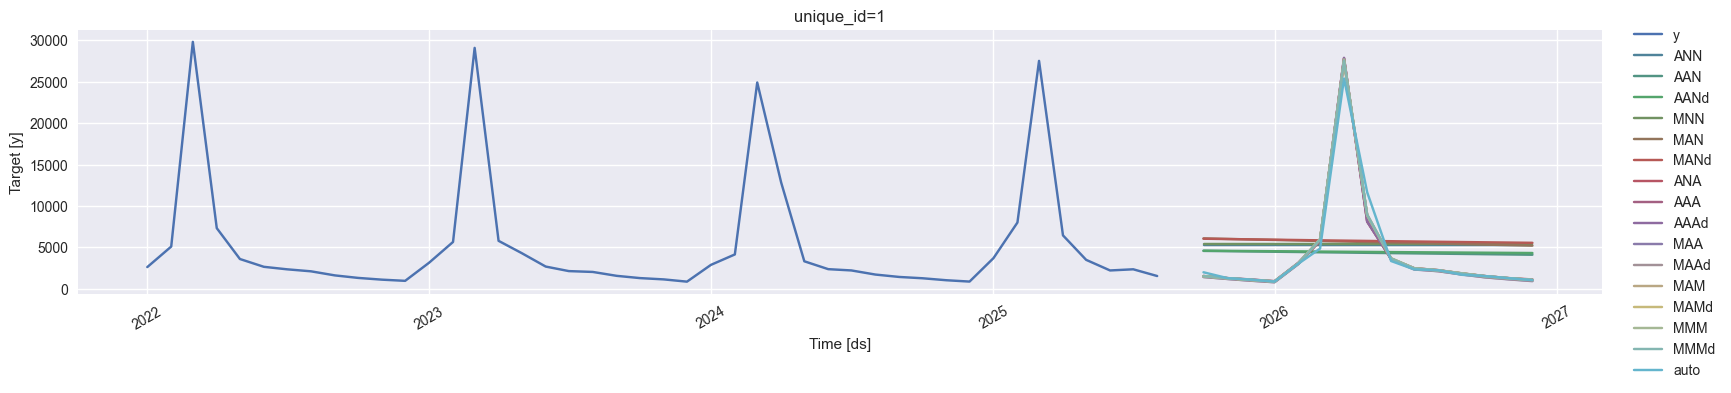

In [11]:
sf = sf.fit(reno)
plot_series(reno, fc)

In [12]:
# Guardar el mejor modelo (ajustar índice según resultados)
fitted_best_model_01 = sf.fitted_[0,13].model_

**Observaciones**

- El mejor modelo es el ETS(MMM)
- El modelo TBATS no mejora el desempeño del ETS(MMM)

## Con exógenas

### Model config

In [13]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------

H = 15
models = [
    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),

]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [14]:
sf = StatsForecast(models=models, freq="M")

sf = sf.fit(
    df=reno_x,
    target_col="y",
)

# Crear X_future con valores específicos para la variable exógena
X_future = build_X_future_step(reno_x, H, freq='M', exog_values={'Cambio_tarifa': 1})

# Generar pronósticos con variables exógenas usando la función wrapper
fc = forecast_with_corrected_dates(sf, df=reno_x, h=H, level=[90, 95], fitted=True, X_df=X_future, freq='M')

pronostico_auto_arima_x = fc.copy()

# # Obtener valores ajustados para análisis posterior
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

In [15]:
fc

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,2214.94,-231.78,161.59,4268.29,4661.66
1,1,2025-10-31,1342.27,-1883.92,-1365.23,4049.77,4568.45
2,1,2025-11-30,1168.97,-2057.21,-1538.53,3876.47,4395.16
3,1,2025-12-31,917.68,-2308.51,-1789.82,3625.17,4143.86
4,1,2026-01-31,3084.10,-142.08,376.60,5791.60,6310.29
5,1,2026-02-28,4909.79,1683.61,2202.29,7617.29,8135.98
6,1,2026-03-31,25421.52,22195.33,22714.02,28129.02,28647.70
7,1,2026-04-30,11678.71,8452.53,8971.21,14386.21,14904.90
8,1,2026-05-31,3397.36,171.18,689.86,6104.86,6623.55
9,1,2026-06-30,2386.81,-839.37,-320.68,5094.31,5613.00


### Model Evaluation

In [16]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results

,model,rmse,mae,mape
0,auto,1013.29,488.58,12.40


### Decomposition

In [17]:
fitted_best_model_02 = sf.fitted_[0,0].model_

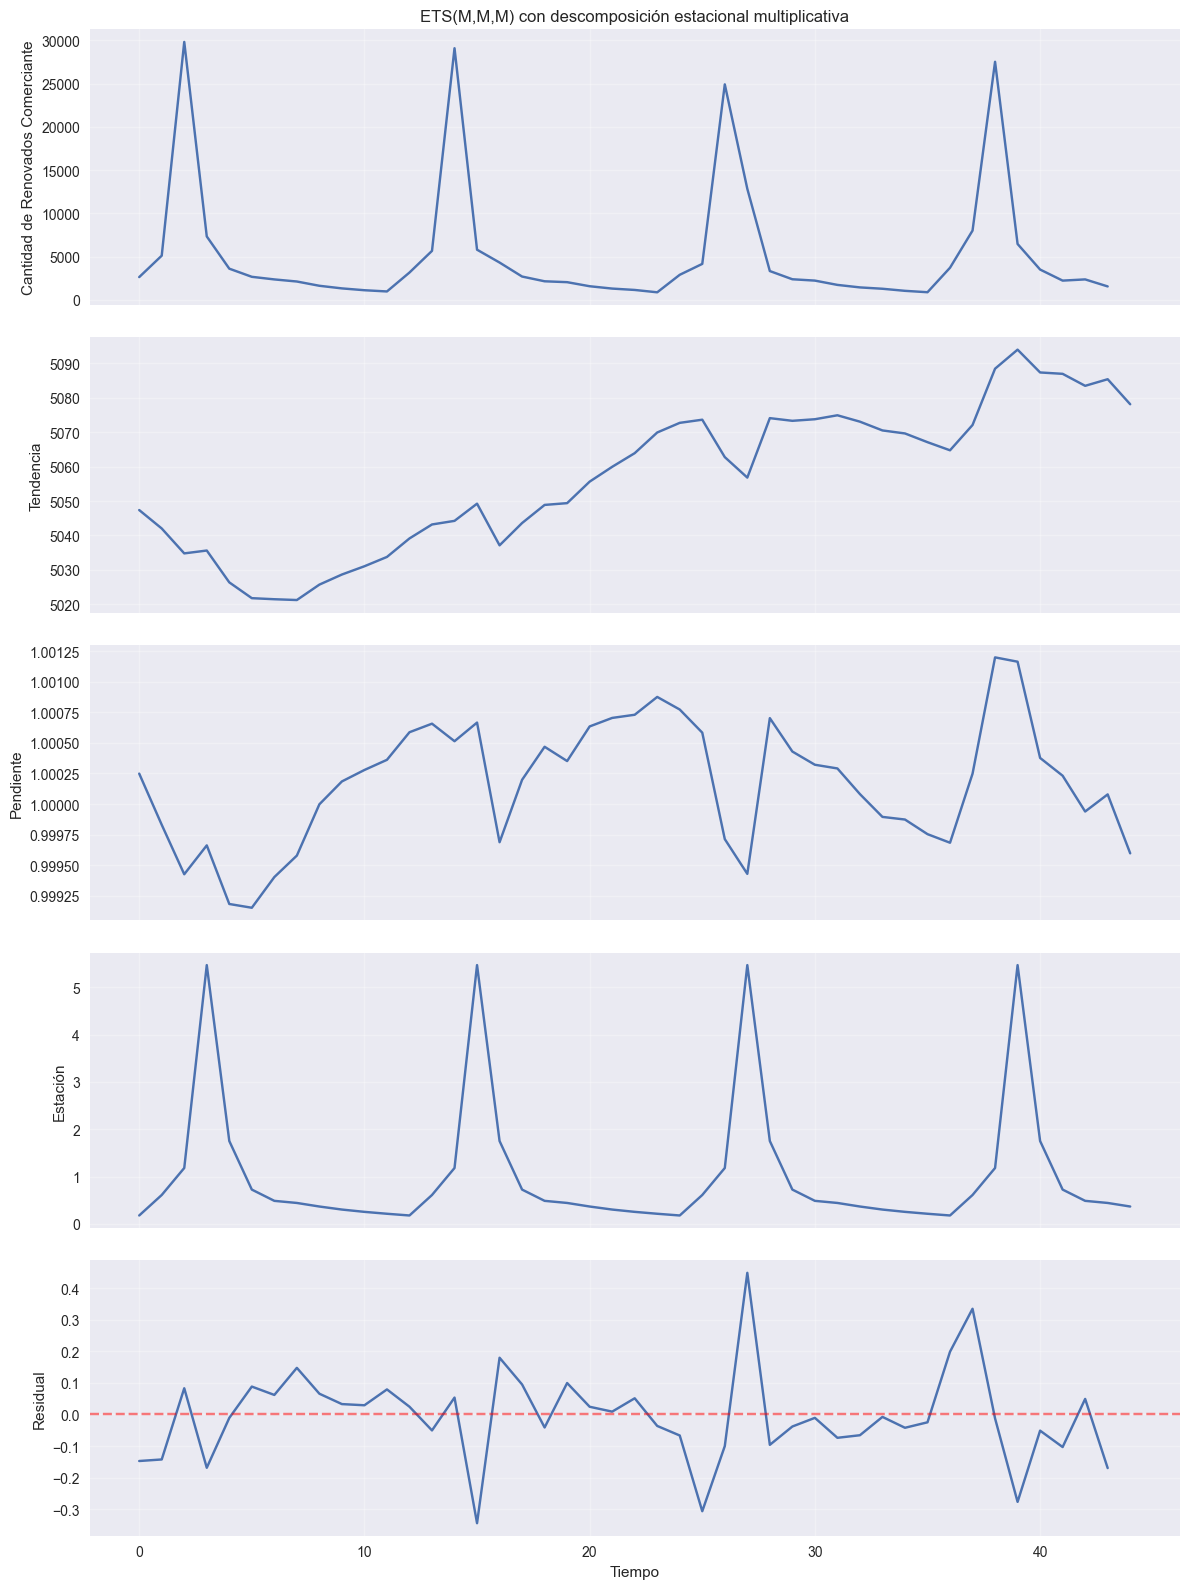

In [18]:
# Crear gráfico de descomposición usando la función
fig, axes = plot_ets_decomposition(
    original_data=reno_x["y"].values,
    fitted_model=fitted_best_model_01,
    title="ETS(M,M,M) con descomposición estacional multiplicativa",
    y_label="Cantidad de Renovados Comerciante"
)
plt.show()

### Residuals check

##### Decomposition model

In [19]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales_2 = fitted_best_model_02["residuals"]
fitted_val_2 = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values_2 = reno["y"].values


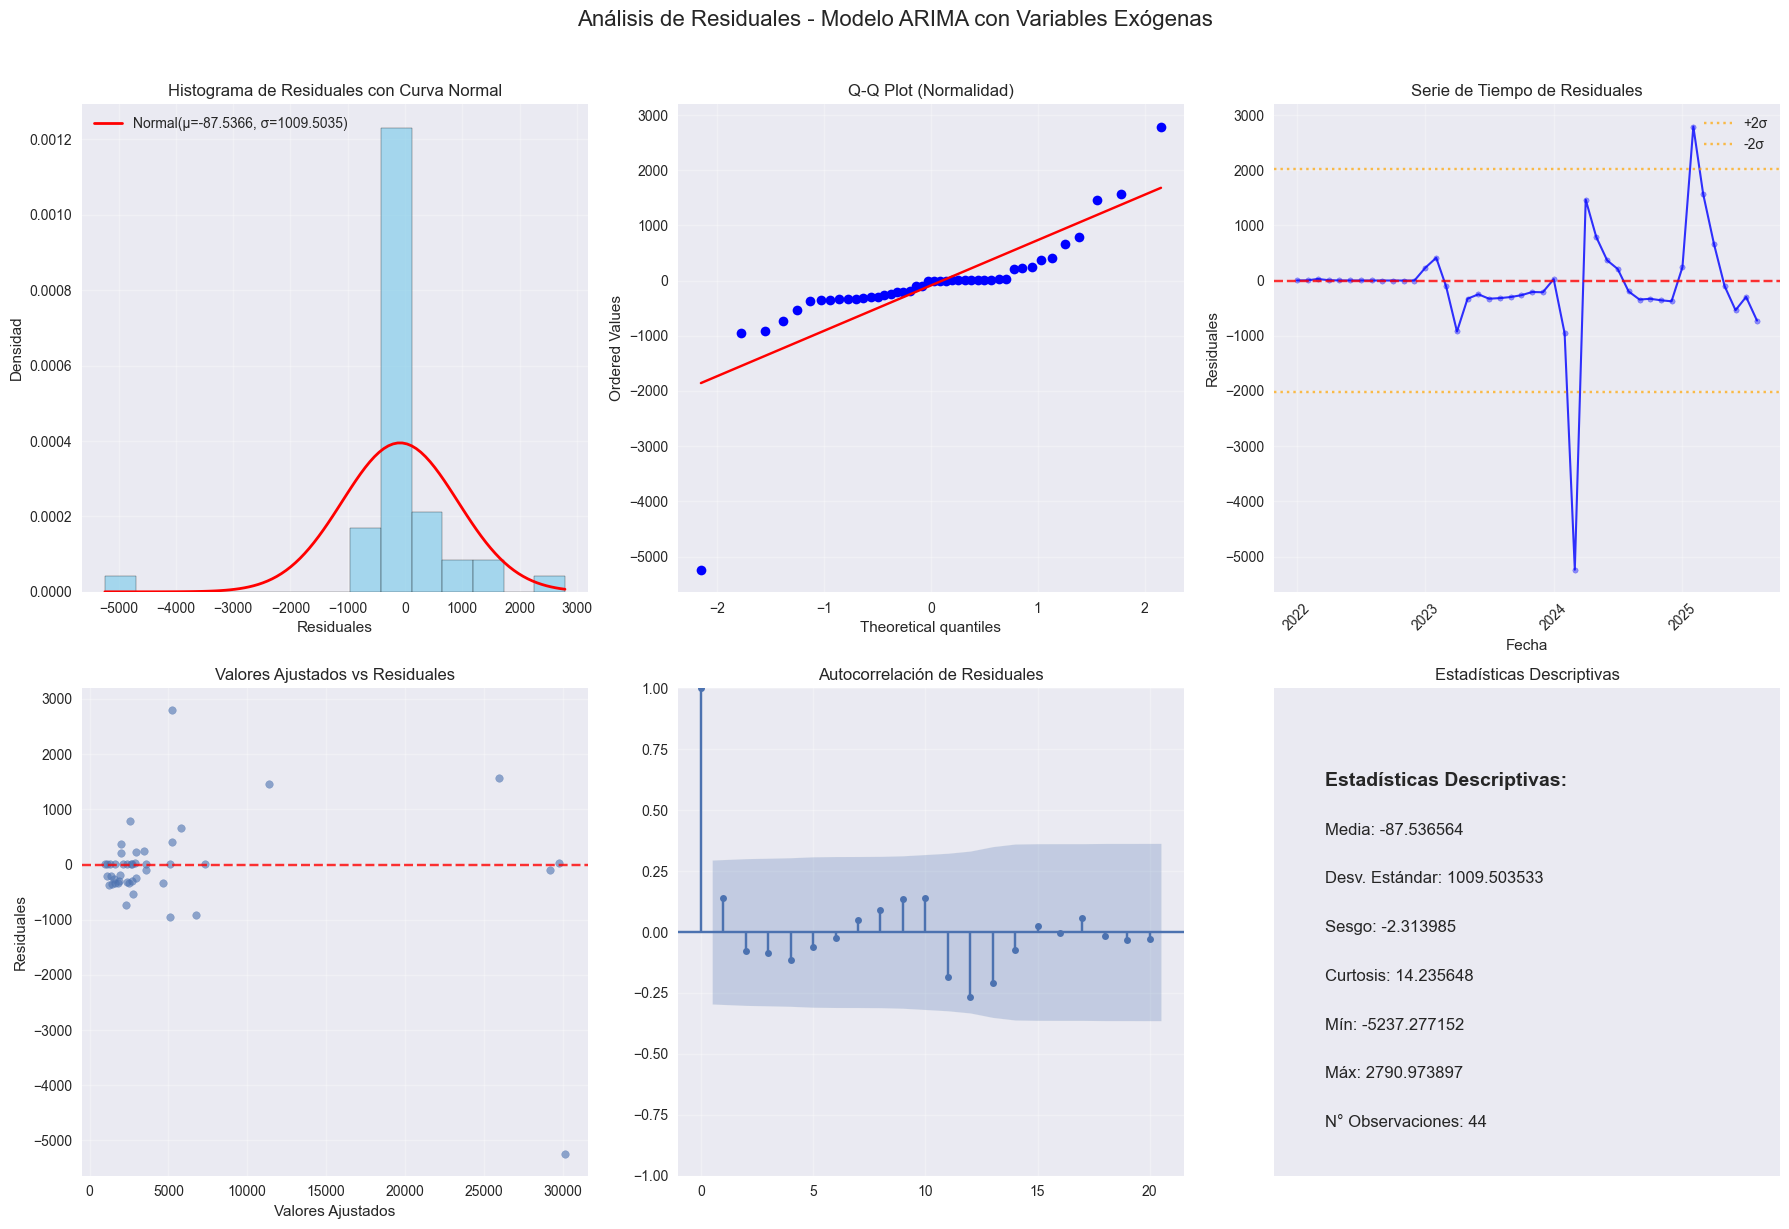

In [20]:
# Crear análisis gráfico de residuales para el modelo ARIMA con variables exógenas
fig, axes = plot_residual_analysis(
    residuals=residuales_2,
    fitted_values=fitted_val_2,
    title="Análisis de Residuales - Modelo ARIMA con Variables Exógenas",
    bins=15,
    lags=20,
    dates=reno_x["ds"]  # Agregar las fechas para el eje x del gráfico temporal
)
plt.show()

In [21]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Extraer residuales
residuales = fitted_best_model_01["residuals"]
fitted_val = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values = reno["y"].values


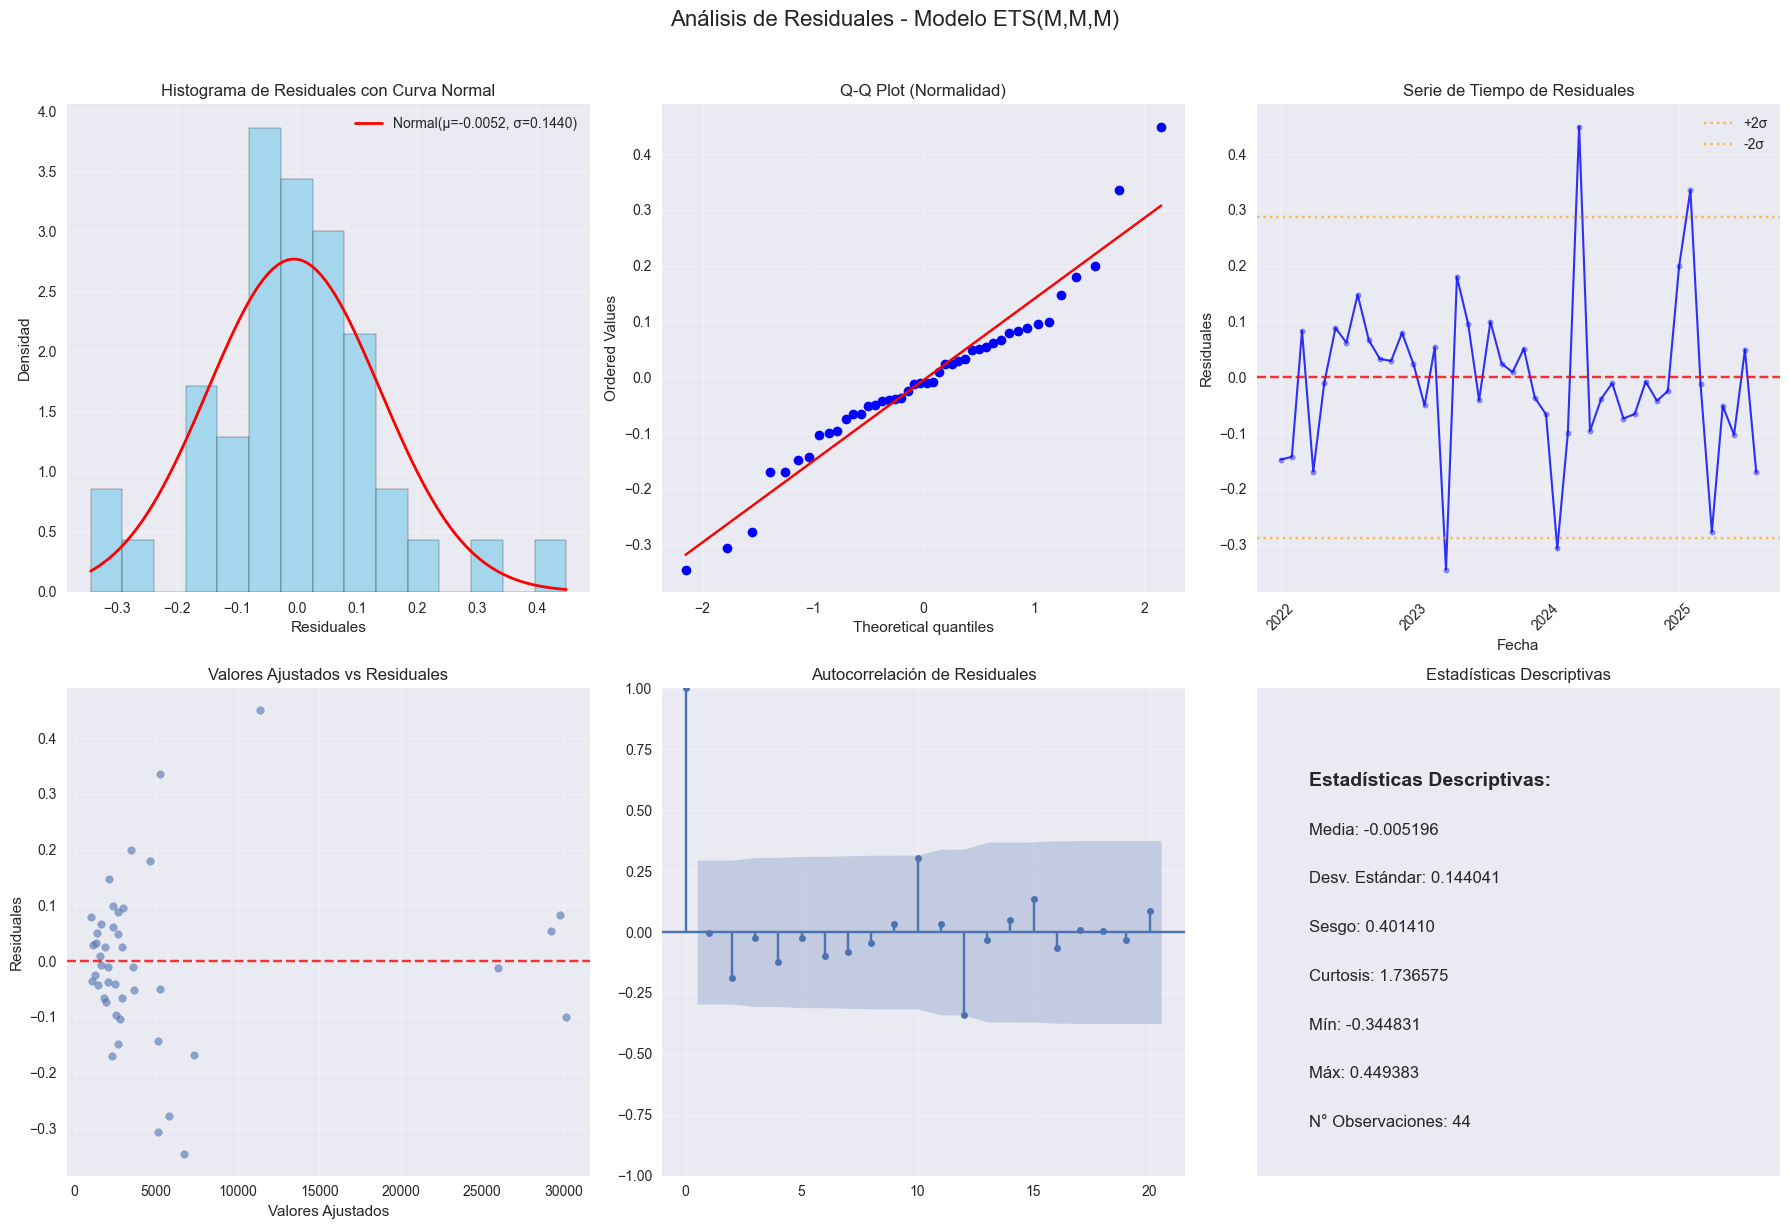

In [22]:
# Crear análisis gráfico de residuales usando la función
fig, axes = plot_residual_analysis(
    residuals=residuales,
    fitted_values=fitted_val,
    title="Análisis de Residuales - Modelo ETS(M,M,M)",
    bins=15,
    lags=20,
    dates=reno["ds"]  # Agregar las fechas para el eje x del gráfico temporal
)
plt.show()

In [23]:
# Realizar todas las pruebas estadísticas de residuales usando la función
results_residuales = perform_residual_tests(
    residuals=residuales,
    title="Análisis Estadístico de Residuales - Modelo ETS(M,M,M)",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ETS(M,M,M)

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.951458
   p-valor: 0.062346
   Conclusión: No se rechaza normalidad

Jarque-Bera Test:
   Estadístico: 6.710392
   p-valor: 0.034903
   Sesgo: 0.401410
   Curtosis: 4.736575
   Conclusión: Residuales NO siguen distribución normal

Anderson-Darling Test:
   Estadístico: 0.727652
   Valor crítico (5%): 0.730000
   Conclusión: No se rechaza normalidad


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 9.017816
   p-valor: 0.530414
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.949632
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 0.807863
   p-valor: 0.368753
   Estadístico F: 0.785565
   p-valor F: 0.380491
   Conclusión: No hay heterocedastic

In [24]:
# Análisis de residuales del modelo ARIMA
results_arima = perform_residual_tests(
    residuals=residuales_2,
    title="Análisis Estadístico de Residuales - Modelo ARIMA con Variables Exógenas",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ARIMA CON VARIABLES EXÓGENAS

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.650066
   p-valor: 0.000000
   Conclusión: Residuales NO siguen distribución normal

Jarque-Bera Test:
   Estadístico: 410.798235
   p-valor: 0.000000
   Sesgo: -2.313985
   Curtosis: 17.235648
   Conclusión: Residuales NO siguen distribución normal

Anderson-Darling Test:
   Estadístico: 4.814279
   Valor crítico (5%): 0.730000
   Conclusión: Residuales NO siguen distribución normal


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 5.276557
   p-valor: 0.871955
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.699303
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 0.863536
   p-valor: 0.352751
   Estadístico F: 0.840786
   p-

# Forecast

**Observaciones**

- Para este caso, modelamos meses de dos formas diferentes. Todos los meses a excepción de Marzo serán modelados usando ETS incluyendo datos de un año después de la pandemia. Este modelo presenta el mejor comportamiento para captar la estacionalidad y tendencia de la serie, sin embargo, es débil en captar la variabilidad que hay a lo largo de los años durante el mes de marzo. Esto ocurre porque fenómenos exógenos (como intervenciones de política, cambios en la tarifa, o evento extraordinarios), pueden tener un efecto considerable y no son estables, por lo tanto, se requieren incluir otras variables para captarlos. Desafortunadamente, este modelo no permite agregar variables exogénas, por lo tanto se plantea un modelo híbrido para proyectar específicamente el mes de marzo con un modelo que si lo permita.

- El segundo modelo, no es el mejor para captar los patrones tendenciales y estacionales sobre los demás meses, pero permite incluir el efecto de la intervención. En este caso, asumimos que el efecto está captado por la introducción del cambio tarifario a partir de 2025. A partir de este modelo predecimos el mes de marzo.

In [25]:
pronostico_ets = pronostico_ets[["ds", "MMM", "MMM-lo-90", "MMM-hi-90", "MMM-lo-95", "MMM-hi-95"]]
pronostico_ets

,ds,MMM,MMM-lo-90,MMM-hi-90,MMM-lo-95,MMM-hi-95
0,2025-09-30,1546.41,1069.18,2023.63,977.76,2115.05
1,2025-10-31,1298.90,821.68,1776.12,730.26,1867.55
2,2025-11-30,1094.74,617.52,1571.96,526.09,1663.38
3,2025-12-31,910.26,433.04,1387.48,341.62,1478.90
4,2026-01-31,3102.89,2625.67,3580.12,2534.25,3671.54
5,2026-02-28,5990.21,5512.99,6467.43,5421.56,6558.85
6,2026-03-31,27691.71,27213.93,28169.49,27122.40,28261.02
7,2026-04-30,8871.25,8393.12,9349.37,8301.53,9440.97
8,2026-05-31,3675.92,3189.36,4162.47,3096.15,4255.68
9,2026-06-30,2470.67,1843.66,3097.67,1723.54,3217.79


In [26]:
pronostico_auto_arima_x

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,2214.94,-231.78,161.59,4268.29,4661.66
1,1,2025-10-31,1342.27,-1883.92,-1365.23,4049.77,4568.45
2,1,2025-11-30,1168.97,-2057.21,-1538.53,3876.47,4395.16
3,1,2025-12-31,917.68,-2308.51,-1789.82,3625.17,4143.86
4,1,2026-01-31,3084.10,-142.08,376.60,5791.60,6310.29
5,1,2026-02-28,4909.79,1683.61,2202.29,7617.29,8135.98
6,1,2026-03-31,25421.52,22195.33,22714.02,28129.02,28647.70
7,1,2026-04-30,11678.71,8452.53,8971.21,14386.21,14904.90
8,1,2026-05-31,3397.36,171.18,689.86,6104.86,6623.55
9,1,2026-06-30,2386.81,-839.37,-320.68,5094.31,5613.00


In [27]:
# Crear pronóstico híbrido ETS-SARIMAX-MIX (ESM)
pronosticos_final = create_hybrid_forecast(
    ets_forecast=pronostico_ets,
    sarimax_forecast=pronostico_auto_arima_x,
    target_year=2026,
    target_month=3,
    ets_main_col='MMM',
    sarimax_main_col='auto',
    hybrid_alias='ESM',
    show_comparison=True
)

pronosticos_final

COMPARACIÓN DE PRONÓSTICOS PARA 2026-03
---------------------------------------------
ETS (Original):     27,691.71
SARIMAX:           25,421.52
ESM (Final):       25,421.52


,ds,ESM,ESM-lo-90,ESM-hi-90,ESM-lo-95,ESM-hi-95
0,2025-09-30,1546.41,1069.18,2023.63,977.76,2115.05
1,2025-10-31,1298.90,821.68,1776.12,730.26,1867.55
2,2025-11-30,1094.74,617.52,1571.96,526.09,1663.38
3,2025-12-31,910.26,433.04,1387.48,341.62,1478.90
4,2026-01-31,3102.89,2625.67,3580.12,2534.25,3671.54
5,2026-02-28,5990.21,5512.99,6467.43,5421.56,6558.85
6,2026-03-31,25421.52,22714.02,28129.02,22195.33,28647.70
7,2026-04-30,8871.25,8393.12,9349.37,8301.53,9440.97
8,2026-05-31,3675.92,3189.36,4162.47,3096.15,4255.68
9,2026-06-30,2470.67,1843.66,3097.67,1723.54,3217.79


### 

## Análisis de Variación Esperada para 2026

In [34]:
# CÁLCULO DE VARIACIÓN ANUAL 2025 vs 2026
# ===============================================================

# Crear una copia temporal con nombres de columnas consistentes
pronosticos_temp = pronosticos_final.copy()
# Si la columna ya se llama 'ds', no necesitamos renombrar
if 'Fecha' in pronosticos_temp.columns:
    pronosticos_temp = pronosticos_temp.rename(columns={'Fecha': 'ds'})

# Verificar el período de datos históricos disponibles
print("🔍 VERIFICACIÓN DE DATOS DISPONIBLES")
print("=" * 70)
print(f"📊 Período histórico completo: {reno['ds'].min()} a {reno['ds'].max()}")
print(f"📊 Total de observaciones históricas: {len(reno)}")

# Filtrar datos de 2025 disponibles (desde enero hasta el último mes disponible)
reno_2025 = reno[reno["ds"] >= "2025-01-01"].copy()
print(f"\n📅 Datos históricos de 2025:")
print(f"   - Período: {reno_2025['ds'].min()} a {reno_2025['ds'].max()}")
print(f"   - Total meses: {len(reno_2025)}")
print(f"   - Último mes incluido: {reno_2025['ds'].max().strftime('%B %Y')}")

# Paso 1: Calcular el total histórico de 2025
# -------------------------------------------------------
total_2025_historico = reno_2025["y"].sum()
print(f"\n📊 Total 2025 histórico: {total_2025_historico:,.0f} renovados")

# Paso 2: Identificar qué meses de 2025 necesitan pronóstico
# -------------------------------------------------------
ultimo_mes_historico = reno_2025['ds'].max()
print(f"\n🔮 Pronósticos necesarios para completar 2025:")

# Filtrar pronósticos que completan 2025 (después del último mes histórico)
pronosticos_2025_restante = pronosticos_temp[
    (pronosticos_temp["ds"] > ultimo_mes_historico) & 
    (pronosticos_temp["ds"] <= "2025-12-31")
]

if len(pronosticos_2025_restante) > 0:
    total_pronosticos_2025 = pronosticos_2025_restante["ESM"].sum()
    print(f"   - Meses pronosticados: {len(pronosticos_2025_restante)}")
    print(f"   - Período: {pronosticos_2025_restante['ds'].min()} a {pronosticos_2025_restante['ds'].max()}")
    print(f"   - Total pronósticos 2025: {total_pronosticos_2025:,.0f} renovados")
else:
    total_pronosticos_2025 = 0
    print(f"   - No se requieren pronósticos (año 2025 completo)")

# Total 2025 proyectado completo
total_2025_completo = total_2025_historico + total_pronosticos_2025
print(f"\n📊 Total 2025 proyectado completo: {total_2025_completo:,.0f} renovados")

# Paso 3: Calcular el total proyectado de 2026
# ----------------------------------------------
pronosticos_2026 = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2026-01-01") & 
    (pronosticos_temp["ds"] <= "2026-12-31")
]

total_2026_proyectado = pronosticos_2026["ESM"].sum()
print(f"📊 Total 2026 proyectado: {total_2026_proyectado:,.0f} renovados")
print(f"   - Meses proyectados: {len(pronosticos_2026)}")

# Paso 4: Calcular la variación
# -----------------------------------
variacion_absoluta = total_2026_proyectado - total_2025_completo
variacion_porcentual = (variacion_absoluta / total_2025_completo) * 100

print(f"\n🎯 ANÁLISIS DE VARIACIÓN ANUAL")
print("=" * 70)
print(f"📊 Total 2025 (Proyección completa): {total_2025_completo:,.0f} renovados")
print(f"📊 Total 2026 (Pronóstico):          {total_2026_proyectado:,.0f} renovados")
print(f"📊 Variación Absoluta:               {variacion_absoluta:+,.0f} renovados")
print(f"🎯 VARIACIÓN PORCENTUAL:             {variacion_porcentual:+.2f}%")
print("=" * 70)

# Guardar los resultados
results_corrected = {
    'total_2025_historico': total_2025_historico,
    'total_2025_pronosticos_restantes': total_pronosticos_2025,
    'total_2025_completo': total_2025_completo,
    'total_2026_proyectado': total_2026_proyectado,
    'variacion_absoluta': variacion_absoluta,
    'variacion_porcentual': variacion_porcentual,
    'base_year': 2025,
    'target_year': 2026,
    'total_base_year': total_2025_completo,
    'total_target_year': total_2026_proyectado,
    'absolute_variation': variacion_absoluta,
    'percentage_variation': variacion_porcentual
}

🔍 VERIFICACIÓN DE DATOS DISPONIBLES
📊 Período histórico completo: 2022-01-01 00:00:00 a 2025-08-01 00:00:00
📊 Total de observaciones históricas: 44

📅 Datos históricos de 2025:
   - Período: 2025-01-01 00:00:00 a 2025-08-01 00:00:00
   - Total meses: 8
   - Último mes incluido: August 2025

📊 Total 2025 histórico: 55,364 renovados

🔮 Pronósticos necesarios para completar 2025:
   - Meses pronosticados: 4
   - Período: 2025-09-30 00:00:00 a 2025-12-31 00:00:00
   - Total pronósticos 2025: 4,850 renovados

📊 Total 2025 proyectado completo: 60,214 renovados
📊 Total 2026 proyectado: 57,563 renovados
   - Meses proyectados: 11

🎯 ANÁLISIS DE VARIACIÓN ANUAL
📊 Total 2025 (Proyección completa): 60,214 renovados
📊 Total 2026 (Pronóstico):          57,563 renovados
📊 Variación Absoluta:               -2,652 renovados
🎯 VARIACIÓN PORCENTUAL:             -4.40%


Columnas de reno (datos históricos):
['ds', 'y', 'unique_id']

Columnas de pronosticos_final (datos de pronóstico):
['ds', 'ESM', 'ESM-lo-90', 'ESM-hi-90', 'ESM-lo-95', 'ESM-hi-95']


(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'Pronóstico Híbrido ETS-SARIMAX - Cantidad de Renovados Comerciante'}, xlabel='Fecha', ylabel='Cantidad de Renovados'>)

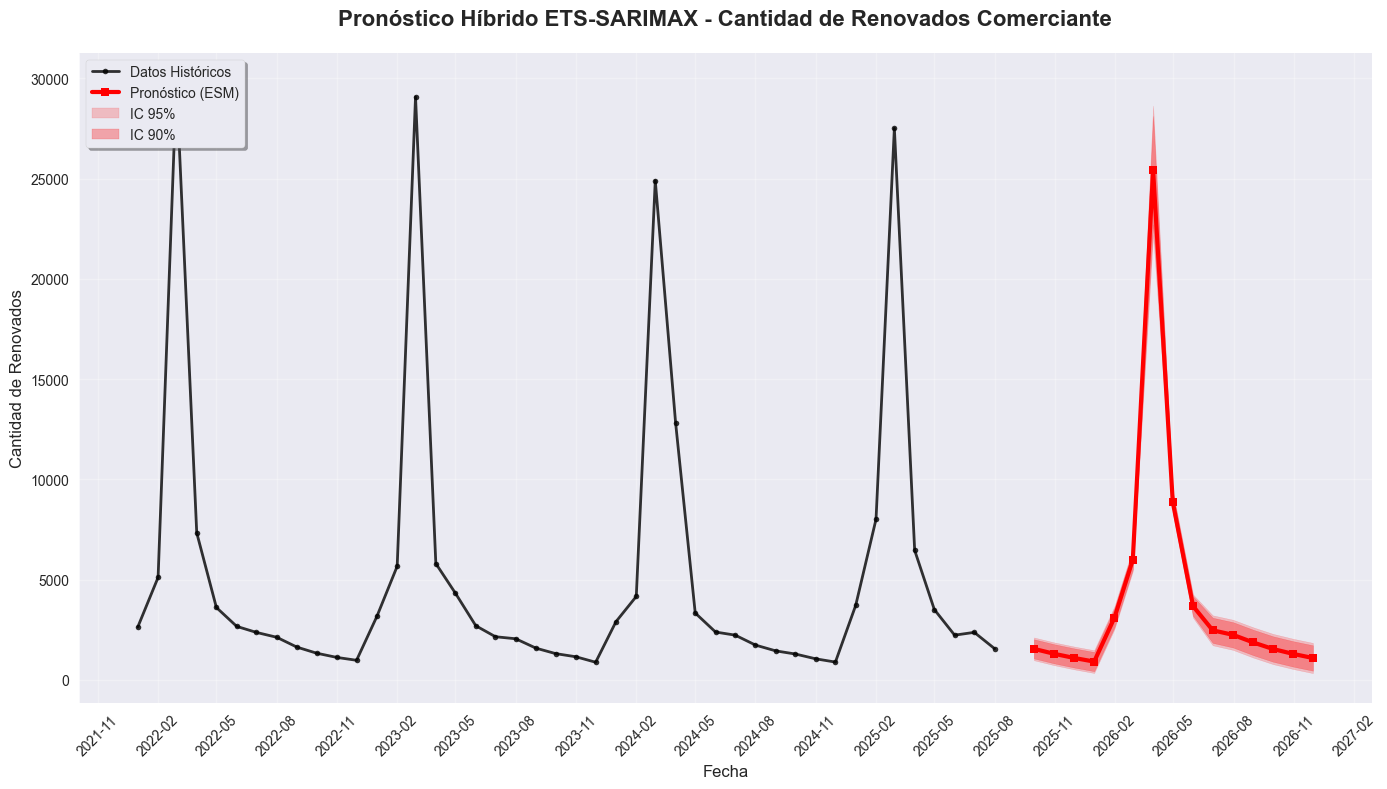

In [28]:
# Verificar columnas disponibles
print("Columnas de reno (datos históricos):")
print(reno.columns.tolist())
print("\nColumnas de pronosticos_final (datos de pronóstico):")
print(pronosticos_final.columns.tolist())

# Visualizar el pronóstico híbrido con intervalos de confianza usando la nueva función
plot_forecast_with_intervals(
    historical_data=reno,
    forecast_data=pronosticos_final,
    main_col='ESM',  # Usar 'ESM' para pronóstico híbrido
    ds_col='ds', 
    y_col='y',
    title='Pronóstico Híbrido ETS-SARIMAX - Cantidad de Renovados Comerciante',
    y_label='Cantidad de Renovados',
    figsize=(14, 8)
)

# Exportar datos 

In [31]:
pronosticos_final = pronosticos_final.rename(columns= {"ds": "Fecha"})

In [32]:
file_path = export_data(
    data=pronosticos_final,
    filename="Pronostico Renovados Comerciante",
    output_dir="data/model_outputs",
    file_format="csv",
    add_timestamp=False
)

📁 DATOS EXPORTADOS EXITOSAMENTE
Archivo:     Pronostico Renovados Comerciante.csv
Directorio:  data/model_outputs
Ruta:        data/model_outputs\Pronostico Renovados Comerciante.csv
Formato:     CSV
Tamaño:      0.00 MB
Filas:       15
Columnas:    6
Fecha:       2025-10-15 01:11:37
